Notebook 6 : Comparaison


---


In [104]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

mlflow.set_tracking_uri("file:../mlruns")
client = MlflowClient()

In [105]:
experiments = {e.name: e.experiment_id for e in client.search_experiments()}
experiments

{'sentiment_airparadis_bert': '521993413225280446',
 'sentiment_airparadis_modele_avance': '549512915106876435',
 'sentiment_airparadis_modele_simple': '854533176105273696',
 'Default': '0'}

In [ ]:
def pick_metric(metrics_dict, candidates):
    for name in candidates:
        if name in metrics_dict:
            return metrics_dict[name]
    return None


def normalize_metrics(metrics_dict):
    m = metrics_dict

    test_accuracy = pick_metric(
        m, ["test_eval_accuracy", "test_accuracy", "eval_accuracy", "accuracy"]
    )
    test_f1 = pick_metric(m, ["test_eval_f1", "test_f1", "eval_f1", "f1"])
    test_precision = pick_metric(
        m, ["test_eval_precision", "test_precision", "eval_precision", "precision"]
    )
    test_recall = pick_metric(
        m, ["test_eval_recall", "test_recall", "eval_recall", "recall"]
    )
    test_roc_auc = pick_metric(
        m, ["test_eval_roc_auc", "test_roc_auc", "eval_roc_auc", "roc_auc"]
    )

    train_loss = pick_metric(m, ["train_loss", "loss"])
    val_loss = pick_metric(m, ["validation_loss", "val_loss", "eval_loss"])
    val_accuracy = pick_metric(m, ["validation_accuracy", "val_accuracy"])

    score = test_f1 if test_f1 is not None else test_accuracy

    return {
        "score_for_sort": score,
        "test_accuracy": test_accuracy,
        "test_f1": test_f1,
        "test_precision": test_precision,
        "test_recall": test_recall,
        "test_roc_auc": test_roc_auc,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
    }


def extract_time_metrics(metrics_dict, run_info):
    m = metrics_dict

    train_runtime = pick_metric(m, ["train_runtime"])
    eval_runtime = pick_metric(m, ["eval_runtime", "test_eval_runtime"])

    train_sps = pick_metric(m, ["train_samples_per_second"])
    eval_sps = pick_metric(
        m, ["eval_samples_per_second", "test_eval_samples_per_second"]
    )

    duration_sec = None
    if run_info.start_time and run_info.end_time:
        duration_sec = (run_info.end_time - run_info.start_time) / 1000.0

    return {
        "train_runtime_metric": train_runtime,
        "eval_runtime_metric": eval_runtime,
        "train_samples_per_second": train_sps,
        "eval_samples_per_second": eval_sps,
        "run_duration_sec": duration_sec,
    }

In [ ]:
def build_model_label(params):

    if "model_type" in params:
        return params["model_type"]

    if "embedding_type" in params:
        emb = params["embedding_type"]
        bi = str(params.get("bidirectional", "False")).lower() == "true"
        prefix = "bilstm" if bi else "lstm"
        return f"{prefix}_{emb}"

    if "model_id" in params:
        return params["model_id"].split("/")[-1]

    return "unknown"


def extract_main_params(params):
    return {
        "model_type": params.get("model_type"),
        "embedding_type": params.get("embedding_type"),
        "bidirectional": params.get("bidirectional"),
        "max_features": params.get("max_features"),
        "ngram_range": params.get("ngram_range"),
        "max_len": params.get("max_len"),
        "max_words": params.get("max_words"),
        "batch_size": params.get("batch_size"),
        "epochs": params.get("epochs", params.get("num_train_epochs")),
        "learning_rate": params.get("learning_rate"),
    }

In [108]:
target_experiments = [
    "sentiment_airparadis_modele_simple",
    "sentiment_airparadis_modele_avance",
    "sentiment_airparadis_bert",
]

rows = []

for exp_name in target_experiments:
    exp_id = experiments[exp_name]
    runs = client.search_runs(
        experiment_ids=[exp_id],
        order_by=[],
        max_results=1000,
    )

    for r in runs:
        params = r.data.params
        metrics = r.data.metrics

        m_norm = normalize_metrics(metrics)
        p_main = extract_main_params(params)
        model_label = build_model_label(params)

        time_metrics = extract_time_metrics(metrics, r.info)

        row = {
            "experiment": exp_name,
            "run_id": r.info.run_id,
            "model_label": model_label,
            **m_norm,
            **p_main,
            **time_metrics,
        }
        rows.append(row)

df_all = pd.DataFrame(rows)
df_all.head()

,experiment,run_id,model_label,score_for_sort,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,train_loss,...,max_len,max_words,batch_size,epochs,learning_rate,train_runtime_metric,eval_runtime_metric,train_samples_per_second,eval_samples_per_second,run_duration_sec
0,sentiment_airparadis_modele_simple,5c675ade24f84326bb10121a64021c0e,logreg_tfidf,0.795198,0.793102,0.795198,0.783223,0.807544,0.874332,NaN,...,None,None,None,None,None,NaN,NaN,NaN,NaN,42.990
1,sentiment_airparadis_modele_simple,4e7ff3827c8d49a29ae98043c9985ad6,logreg_tfidf,0.795198,0.793102,0.795198,0.783223,0.807544,0.874332,NaN,...,None,None,None,None,None,NaN,NaN,NaN,NaN,43.001
2,sentiment_airparadis_modele_simple,dd07d5f86ae14d8196802f3b7595f200,logreg_tfidf,0.795198,0.793102,0.795198,0.783223,0.807544,0.874332,NaN,...,None,None,None,None,None,NaN,NaN,NaN,NaN,40.566
3,sentiment_airparadis_modele_simple,467ee5e3ba75445b9e3d27259b9fcc38,logreg_tfidf,0.795198,0.793102,0.795198,0.783223,0.807544,0.874332,NaN,...,None,None,None,None,None,NaN,NaN,NaN,NaN,41.933
4,sentiment_airparadis_modele_avance,c765b13efe2b4a988d229afbb4a927f5,bilstm_fasttext_cc_300d,0.797342,0.810478,0.797342,0.851624,0.749566,0.897357,0.393079,...,23,50000,256,5,None,NaN,NaN,NaN,NaN,997.852


In [ ]:
best_per_model = (
    df_all.dropna(subset=["score_for_sort"])
    .sort_values("score_for_sort", ascending=False)
    .groupby("model_label", as_index=False)
    .first()
)

best_per_model["run_duration_min"] = best_per_model["run_duration_sec"] / 60
best_per_model["efficiency_f1_per_min"] = (
    best_per_model["test_f1"] / best_per_model["run_duration_min"]
)


best_per_model

,model_label,experiment,run_id,score_for_sort,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,train_loss,...,batch_size,epochs,learning_rate,train_runtime_metric,eval_runtime_metric,train_samples_per_second,eval_samples_per_second,run_duration_sec,run_duration_min,efficiency_f1_per_min
0,ModernBERT-base,sentiment_airparadis_bert,3c865f091fc0404ab81151673c8effa7,0.844107,0.844740,0.844107,0.842804,0.845414,0.921778,0.387263,...,512,3,2e-05,16893.3404,1961.3742,8.879,25.492,18856.256,314.270933,0.002686
1,bilstm_fasttext_cc_300d,sentiment_airparadis_modele_avance,c765b13efe2b4a988d229afbb4a927f5,0.797342,0.810478,0.797342,0.851624,0.749566,0.897357,0.393079,...,256,5,None,NaN,NaN,NaN,NaN,997.852,16.630867,0.047944
2,logreg_tfidf,sentiment_airparadis_modele_simple,5c675ade24f84326bb10121a64021c0e,0.795198,0.793102,0.795198,0.783223,0.807544,0.874332,NaN,...,None,None,None,NaN,NaN,NaN,NaN,42.990,0.716500,1.109836
3,lstm_glove_twitter_100d,sentiment_airparadis_modele_avance,57ddba0ab02e469bb54335361f0bff84,0.826506,0.830406,0.826506,0.841364,0.812164,0.911623,0.348186,...,256,5,None,NaN,NaN,NaN,NaN,718.843,11.980717,0.068986


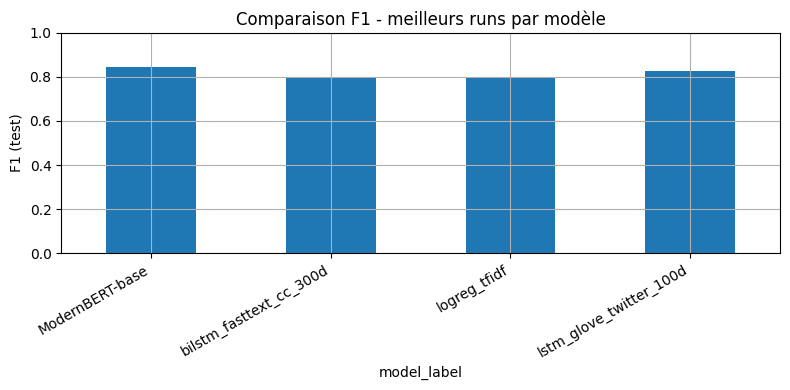

In [110]:
ax = best_per_model.set_index("model_label")["test_f1"].plot(kind="bar")
ax.set_ylabel("F1 (test)")
ax.set_title("Comparaison F1 - meilleurs runs par modèle")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

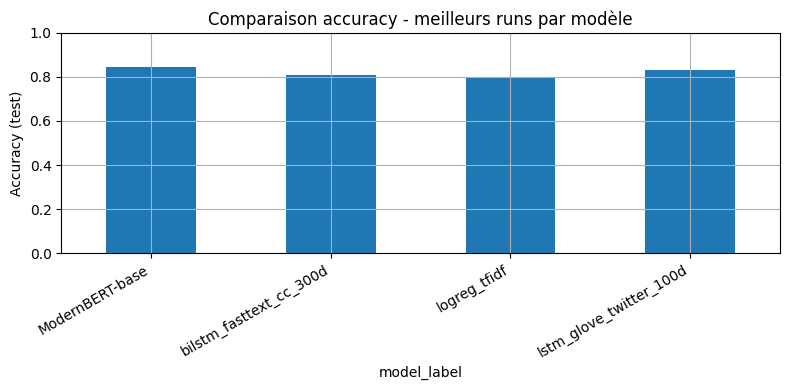

In [111]:
ax = best_per_model.set_index("model_label")["test_accuracy"].plot(kind="bar")
ax.set_ylabel("Accuracy (test)")
ax.set_title("Comparaison accuracy - meilleurs runs par modèle")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

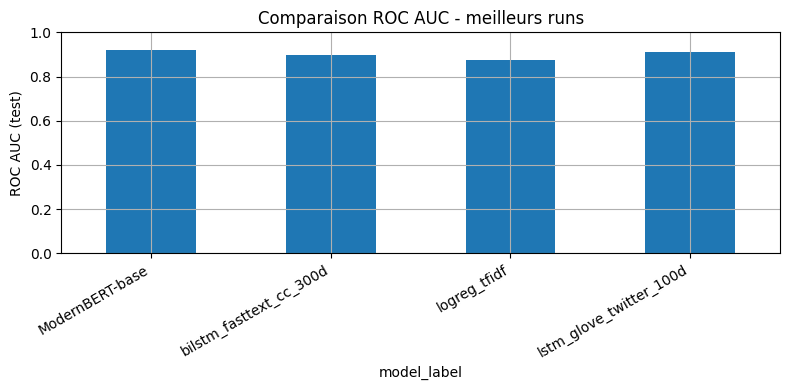

In [112]:
ax = best_per_model.set_index("model_label")["test_roc_auc"].plot(kind="bar")
ax.set_ylabel("ROC AUC (test)")
ax.set_title("Comparaison ROC AUC - meilleurs runs")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

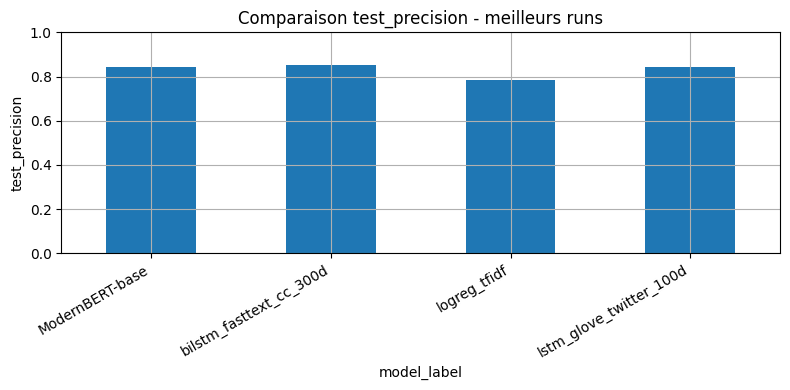

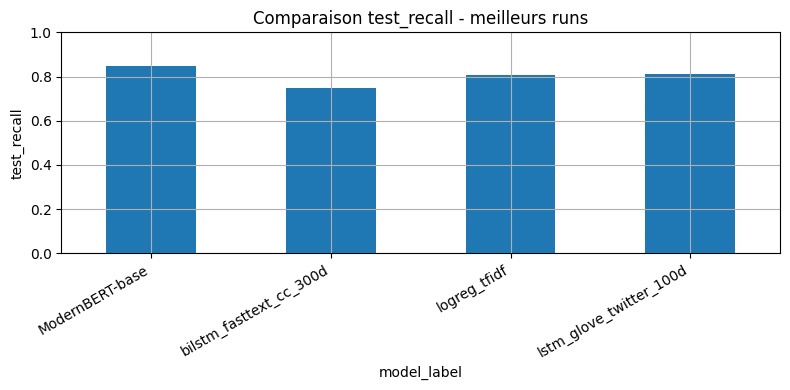

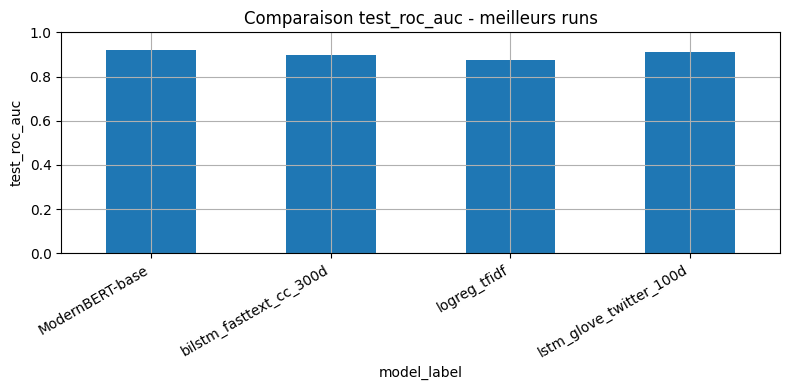

In [113]:
metrics_to_plot = ["test_precision", "test_recall", "test_roc_auc"]

for metric in metrics_to_plot:
    if metric not in best_per_model.columns:
        continue
    ax = best_per_model.set_index("model_label")[metric].plot(kind="bar")
    ax.set_ylabel(metric)
    ax.set_title(f"Comparaison {metric} - meilleurs runs")
    plt.ylim(0, 1)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

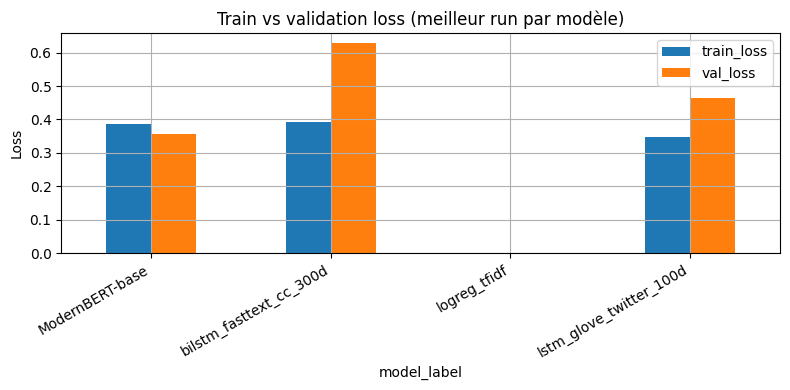

In [114]:
loss_df = best_per_model.set_index("model_label")[["train_loss", "val_loss"]]

ax = loss_df.plot(kind="bar")
ax.set_ylabel("Loss")
ax.set_title("Train vs validation loss (meilleur run par modèle)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

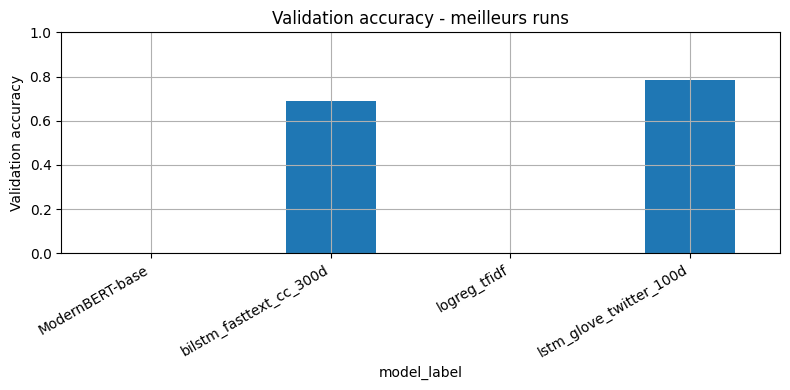

In [115]:
if "val_accuracy" in best_per_model.columns:
    ax = best_per_model.set_index("model_label")["val_accuracy"].plot(kind="bar")
    ax.set_ylabel("Validation accuracy")
    ax.set_title("Validation accuracy - meilleurs runs")
    plt.ylim(0, 1)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

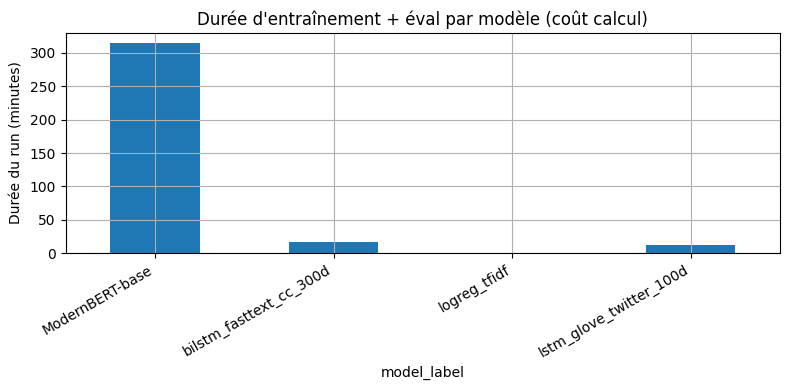

In [116]:
ax = best_per_model.set_index("model_label")["run_duration_min"].plot(kind="bar")
ax.set_ylabel("Durée du run (minutes)")
ax.set_title("Durée d'entraînement + éval par modèle (coût calcul)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

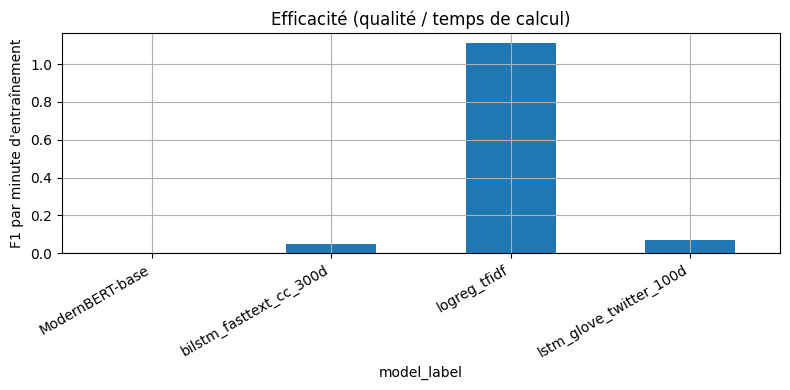

In [117]:
ax = best_per_model.set_index("model_label")["efficiency_f1_per_min"].plot(kind="bar")
ax.set_ylabel("F1 par minute d'entraînement")
ax.set_title("Efficacité (qualité / temps de calcul)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

Zoom sur BERT :


In [118]:
cols_speed = ["train_samples_per_second", "eval_samples_per_second"]
best_per_model[cols_speed]

,train_samples_per_second,eval_samples_per_second
0,8.879,25.492
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN


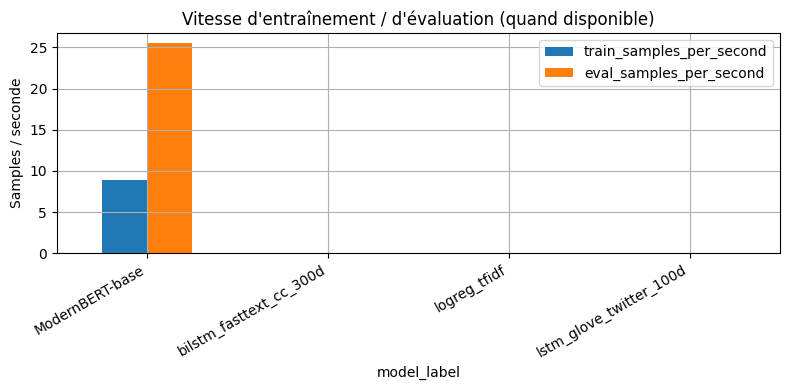

In [119]:
ax = best_per_model.set_index("model_label")[cols_speed].plot(kind="bar")
ax.set_ylabel("Samples / seconde")
ax.set_title("Vitesse d'entraînement / d'évaluation (quand disponible)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

In [120]:
from typing import List


def get_metric_history_df(run_id: str, metric_names: List[str]) -> pd.DataFrame:
    rows = []
    for name in metric_names:
        history = client.get_metric_history(run_id, name)
        for m in history:
            rows.append(
                {
                    "metric": name,
                    "step": m.step,
                    "value": m.value,
                    "timestamp": pd.to_datetime(m.timestamp, unit="ms"),
                }
            )
    return pd.DataFrame(rows)

In [121]:
def plot_metric_history(run_id: str, metric_names: List[str], title: str = None):
    df_hist = get_metric_history_df(run_id, metric_names)
    if df_hist.empty:
        print(f"Aucun historique trouvé pour {metric_names} (run {run_id})")
        return

    for name in metric_names:
        sub = df_hist[df_hist["metric"] == name]
        if sub.empty:
            continue
        plt.plot(sub["step"], sub["value"], marker="o", label=name)

    plt.xlabel("step / epoch")
    plt.ylabel("valeur")
    plt.title(title or f"Historique métriques - run {run_id}")
    plt.legend()
    plt.tight_layout()
    plt.show()

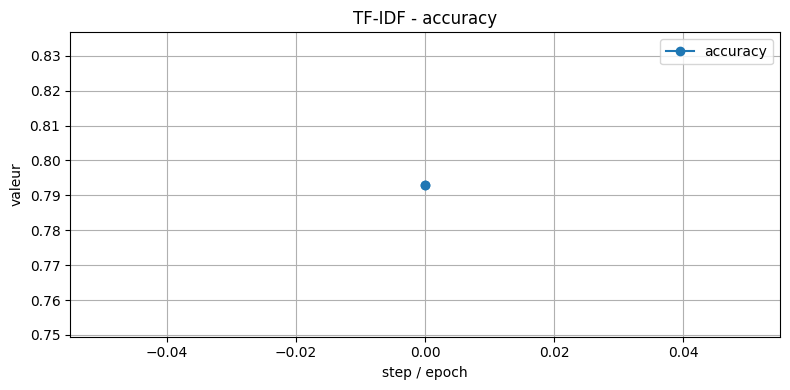

In [122]:
run_tfidf = best_per_model.loc[
    best_per_model["model_label"].str.contains("logreg"), "run_id"
].iloc[0]

plot_metric_history(run_tfidf, ["accuracy"], "TF-IDF - accuracy")

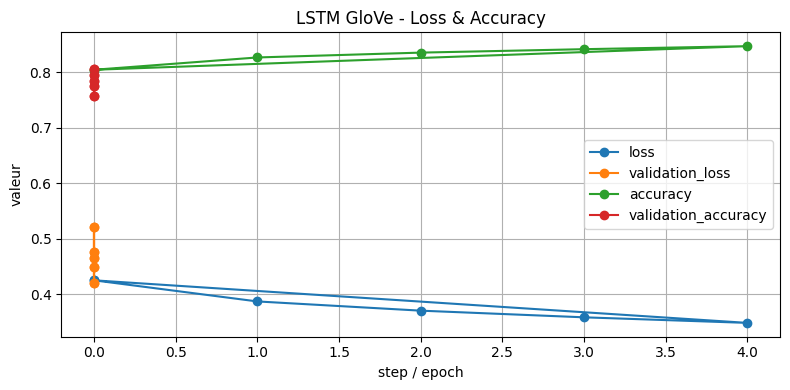

In [123]:
run_glove = best_per_model.loc[
    best_per_model["model_label"].str.contains("glove"), "run_id"
].iloc[0]

plot_metric_history(
    run_glove,
    ["loss", "validation_loss", "accuracy", "validation_accuracy"],
    "LSTM GloVe - Loss & Accuracy",
)

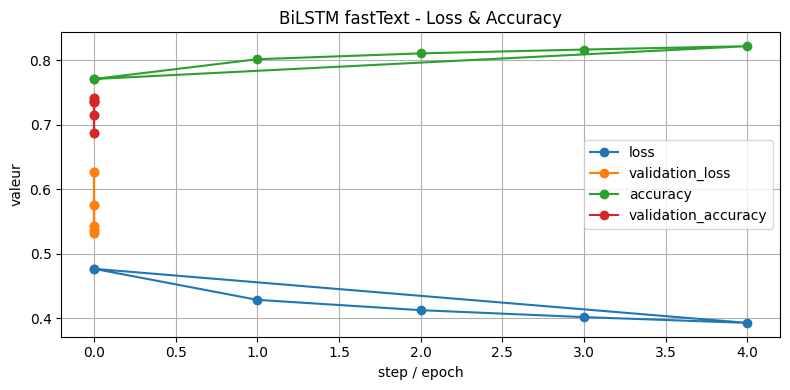

In [124]:
run_fasttext = best_per_model.loc[
    best_per_model["model_label"].str.contains("fasttext"), "run_id"
].iloc[0]

plot_metric_history(
    run_fasttext,
    ["loss", "validation_loss", "accuracy", "validation_accuracy"],
    "BiLSTM fastText - Loss & Accuracy",
)

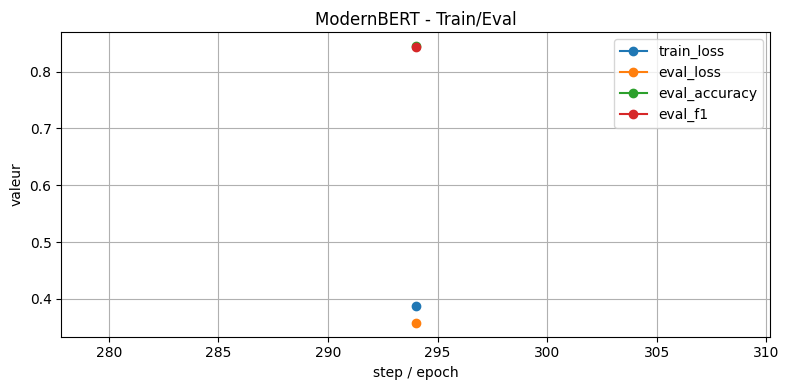

In [125]:
run_bert = best_per_model.loc[
    best_per_model["model_label"].str.contains("Modern", case=False), "run_id"
].iloc[0]

plot_metric_history(
    run_bert,
    ["train_loss", "eval_loss", "eval_accuracy", "eval_f1"],
    "ModernBERT - Train/Eval",
)

---


Comparaison via l'interface de mlflow :


Modèle simple :


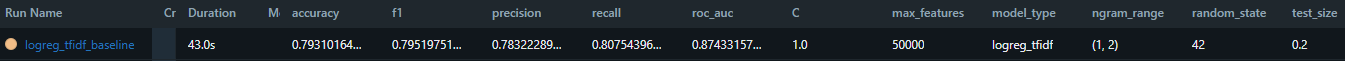


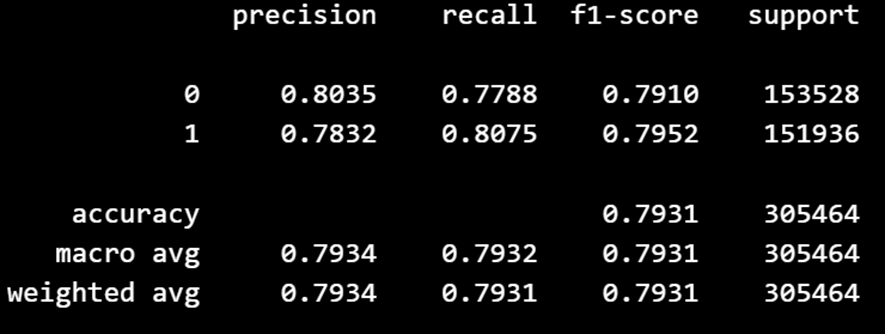


Modèle avancé :


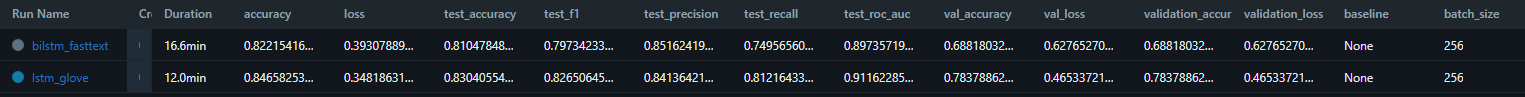


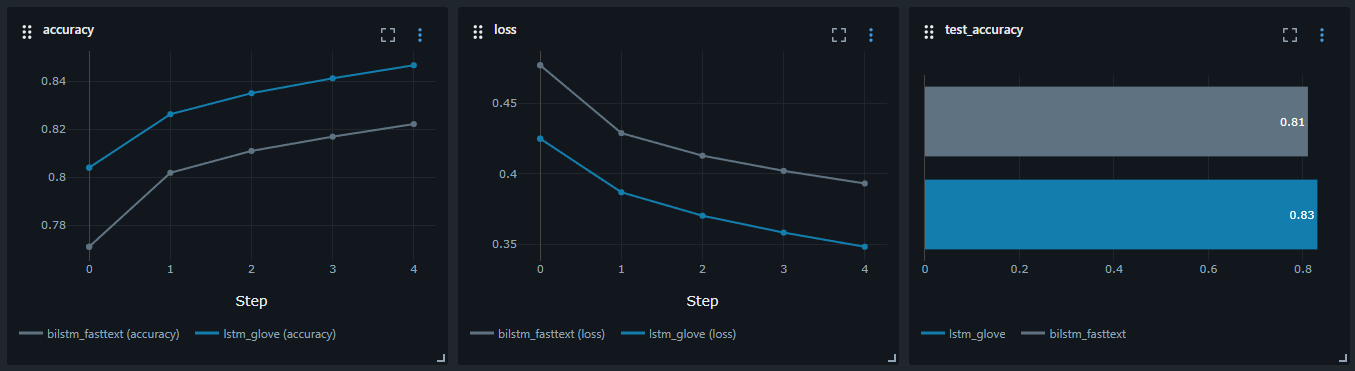


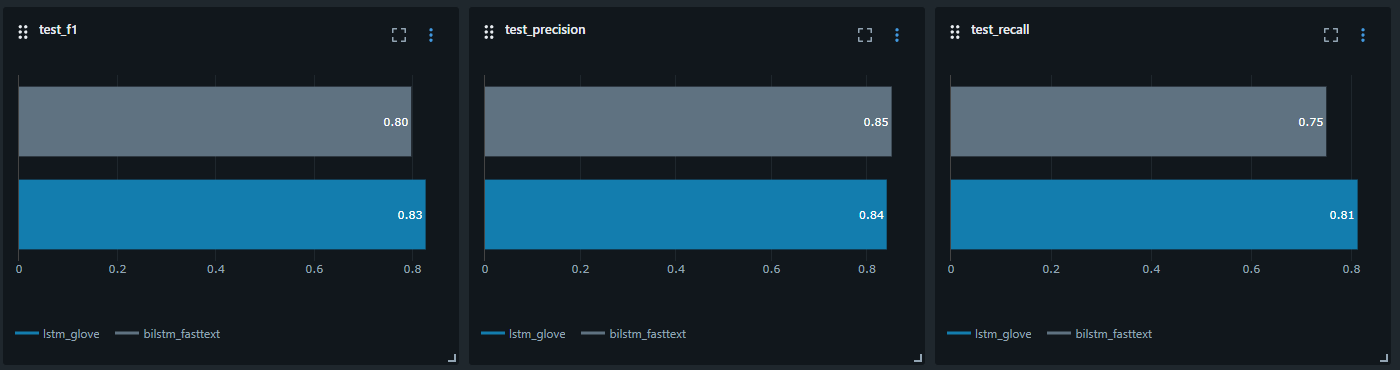


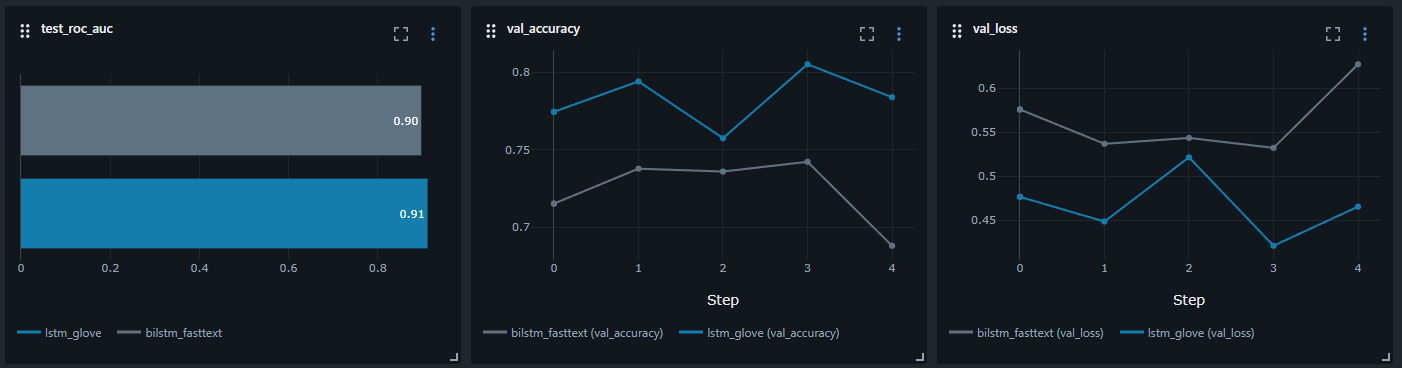


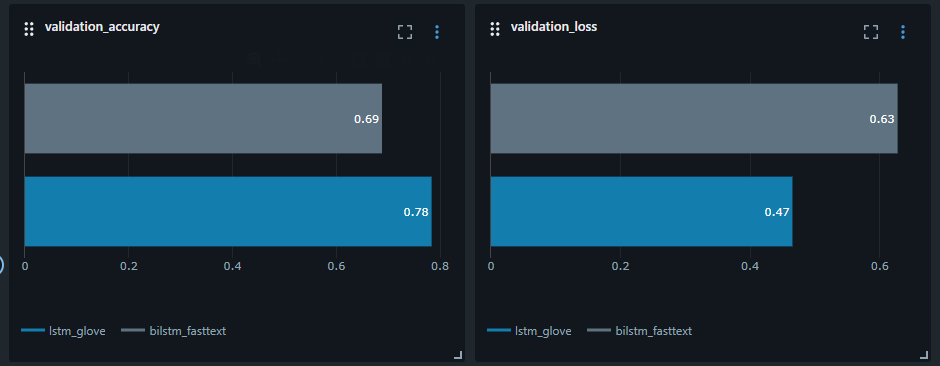


Modèle type ModernBert :


Ici testé sur 3 Run avec taux d'échantillon variant entre 1000 et 50 000 :


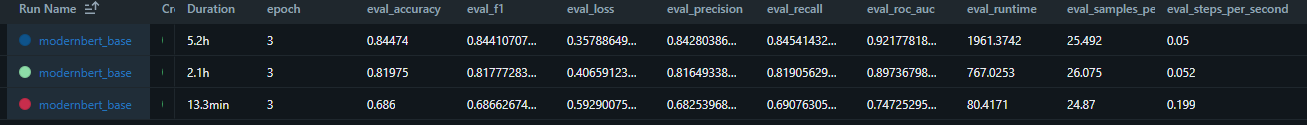


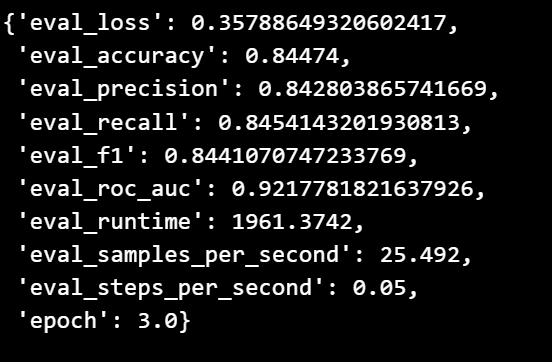


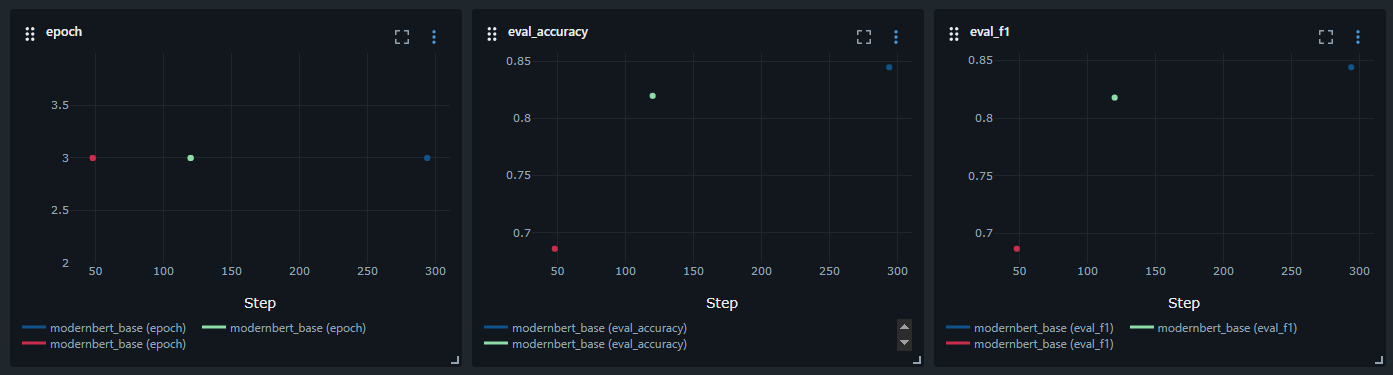


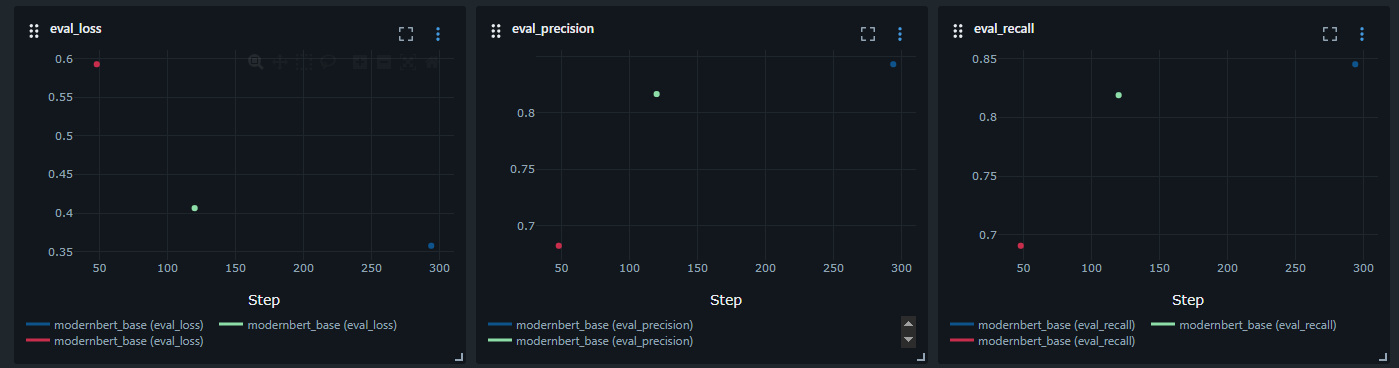


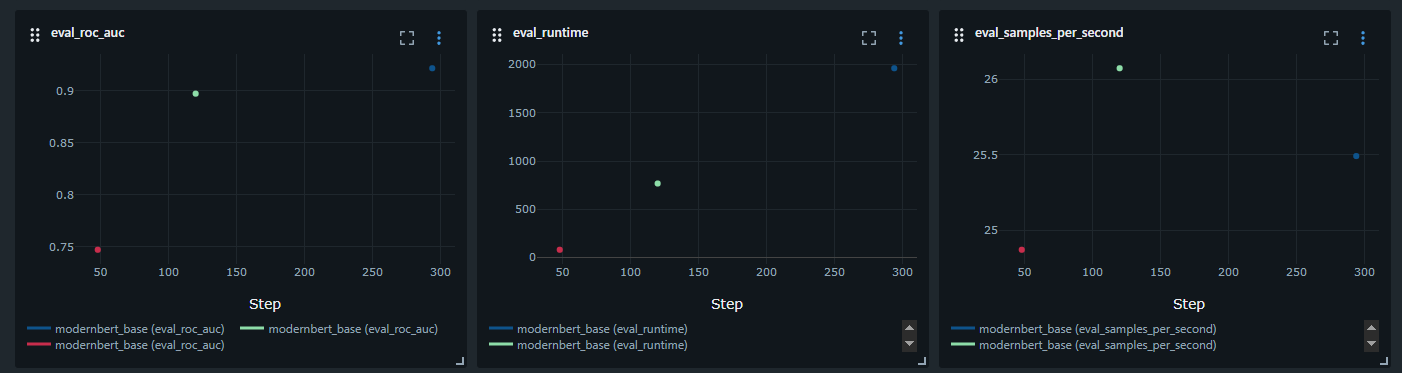


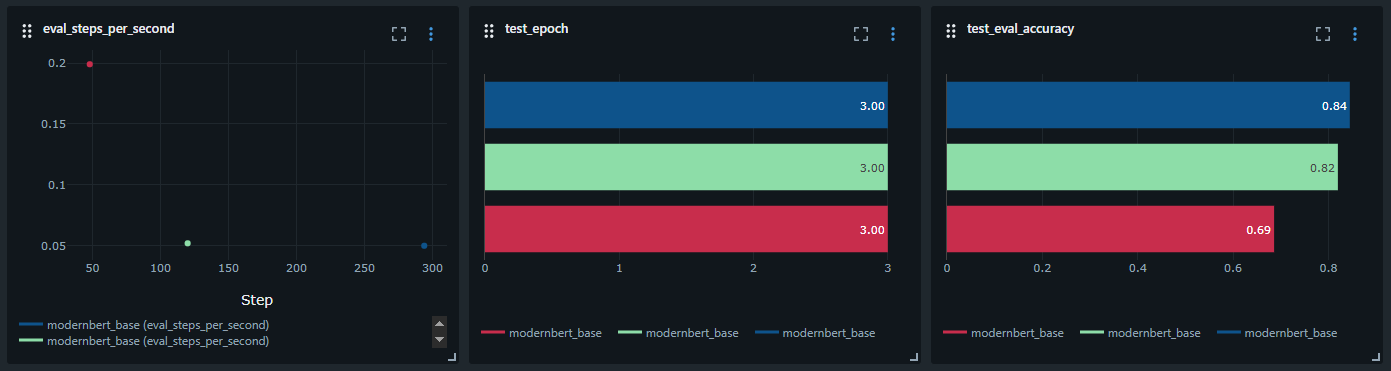


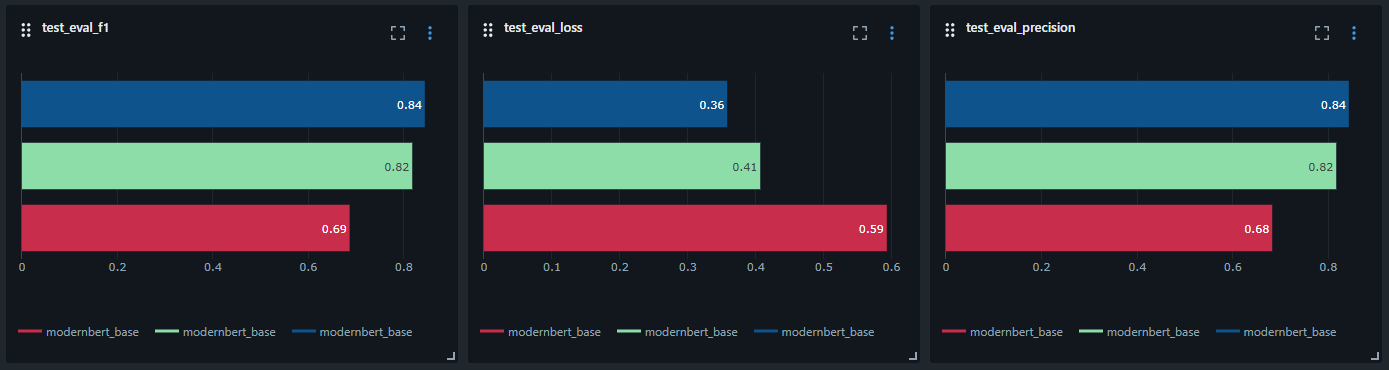


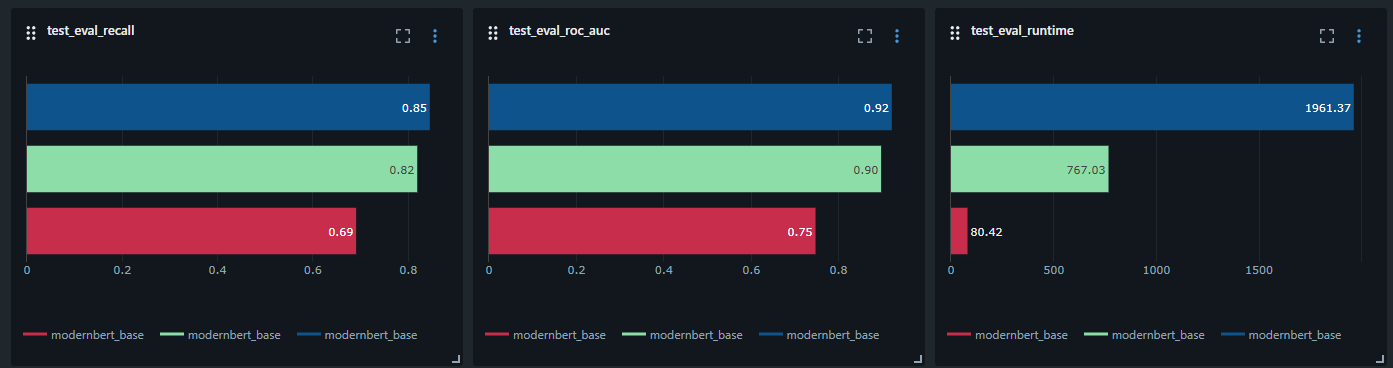


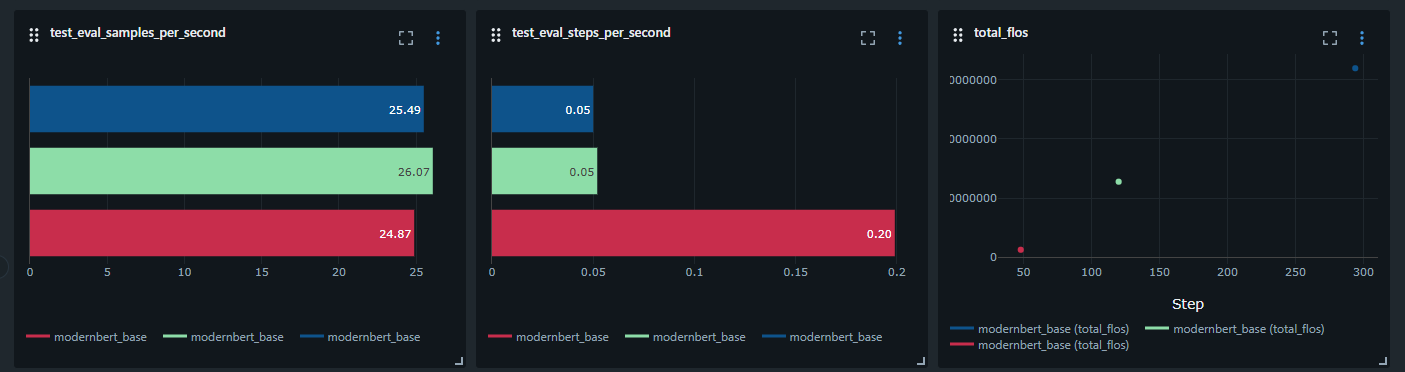


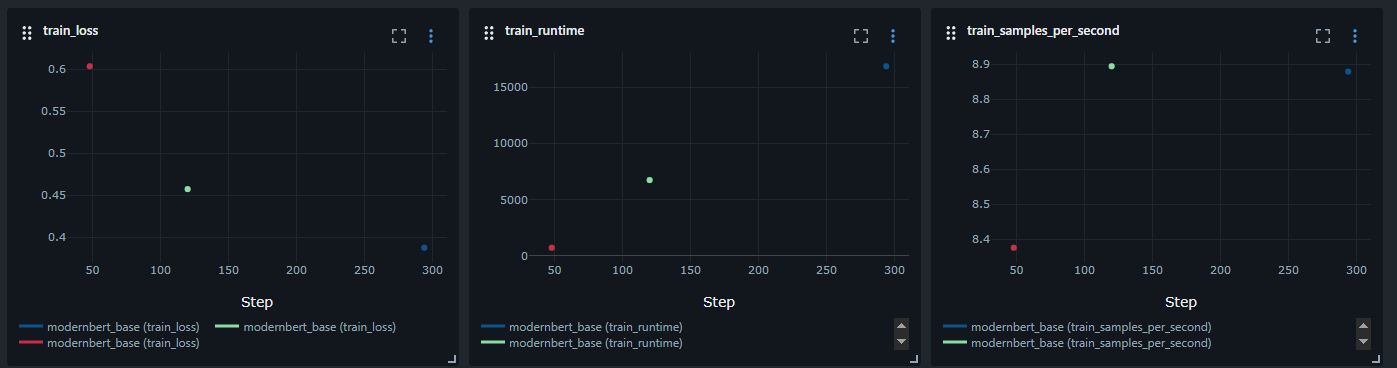


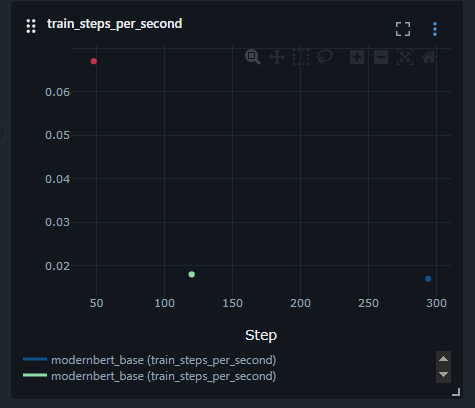
